# Домашнє завдання – Заняття 3: Розробка та навчання нейронної мережі

## Мета
Розробити та навчити нейронну мережу для класифікації або регресії на новому наборі даних, використовуючи методи регуляризації для покращення продуктивності моделі та запобігання перенавчанню.

---

## Кроки для виконання завдання

### 1. Завантаження та попередня обробка даних
- Завантажте набір даних і перевірте його на:
  - Пропущені значення.
  - Аномалії.
  - Некоректні типи даних.
- Виконайте нормалізацію або стандартизацію числових ознак.
- Розділіть дані на:
  - Навчальну вибірку.
  - Тестову вибірку.
  - (За необхідності) Валідаційну вибірку для налаштування гіперпараметрів.

---

### 2. Створення архітектури нейронної мережі
- Розробіть архітектуру з кількома прихованими шарами, використовуючи функцію активації ReLU або іншу, залежно від задачі.
- Налаштуйте вихідний шар:
  - Для класифікації: softmax або sigmoid.
  - Для регресії: один нейрон із лінійною активацією.

---

### 3. Додавання методів регуляризації
- **L2 регуляризація:** Додайте штрафні коефіцієнти до ваг моделі для запобігання перенавчанню.
- **Dropout:** Використовуйте між прихованими шарами для випадкового вимикання нейронів під час навчання.
- **Batch Normalization:** Застосуйте для покращення збіжності та стабільності роботи моделі.

---

### 4. Налаштування параметрів навчання
- Використовуйте оптимальні значення гіперпараметрів, отримані в попередніх завданнях.

---

### 5. Навчання моделі з регуляризацією
- Зосередьтеся на уникненні перенавчання, спостерігаючи за результатами на валідаційній вибірці.

---

### 6. Оцінка продуктивності моделі
- Обчисліть метрики точності або середньоквадратичної помилки.
- Перевірте різницю між навчальною та валідаційною вибірками для виявлення перенавчання.
- Побудуйте:
  - Матрицю невідповідностей для класифікації.
  - Графіки оцінки продуктивності для регресійних моделей.

---

### 7. Візуалізація результатів
- Створіть графіки втрат і точності (для класифікації) або середньоквадратичної помилки (для регресії).
- Проаналізуйте вплив регуляризації на покращення роботи моделі.

---

## Мінімальні вимоги
- Реалізувати нейронну мережу та навчити її на новому наборі даних.
- Досягти стабільної роботи моделі із запобіганням перенавчанню через регуляризацію.
- Виконати базову візуалізацію втрат і продуктивності.

---

## Додаткові рекомендації
- Експериментуйте з гіперпараметрами регуляризації, такими як коефіцієнт L2 або ймовірність Dropout.
- Застосуйте **ранню зупинку (Early Stopping)**, щоб уникнути перенавчання.

---

## Формат виконання
- **.ipynb блокнот:** Код із візуалізацією.
- **.py файл:** Код із прикріпленими зображеннями результатів, опублікований на GitHub.


# Підготовка

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random


In [32]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


# Базові моделі

## Без регуляризації

In [33]:
class BaseNeuralNet(nn.Module):
    def __init__(self):
        super(BaseNeuralNet, self).__init__()
        
    def init_datasets(self, train_dataset=train_dataset, test_dataset=test_dataset):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
    
    def init_loaders(self, train_loader=train_loader, test_loader=test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader

    def start_learning(self, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)  # Без weight_decay

        train_losses, test_losses = [], []

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0

            for images, labels in self.train_loader:  # Використання self.train_loader
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(self.train_loader))

            self.eval()
            test_loss = 0.0
            correct = 0

            with torch.no_grad():
                for images, labels in self.test_loader:  # Використання self.test_loader
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(self.test_loader))
            accuracy = correct / len(self.test_dataset)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

        # Візуалізація
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.title('Train and Test Loss without Regularization')
        plt.show()

        # Приклади передбачень
        self.eval()
        examples = iter(self.test_loader)
        images, labels = next(examples)

        with torch.no_grad():
            outputs = self(images)
            _, predictions = torch.max(outputs, 1)

        fig, axes = plt.subplots(1, 5, figsize=(15, 4))
        for i in range(5):
            index = random.randint(0, len(images) - 1)
            axes[i].imshow(images[index].permute(1, 2, 0))  # CIFAR-10 має 3 канали
            axes[i].set_title(f"True: {self.train_dataset.classes[labels[index]]}, Pred: {self.train_dataset.classes[predictions[index]]}")
            axes[i].axis('off')

        plt.show()


## З регуляризацією

In [34]:

class BaseNeuralNetWithRegularization(nn.Module):
    def __init__(self):
        super(BaseNeuralNetWithRegularization, self).__init__()
        
    def init_datasets(self, train_dataset=train_dataset, test_dataset=test_dataset):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
    
    def init_loaders(self, train_loader=train_loader, test_loader=test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader

    def start_learning(self, epochs=10, lr=0.001, weight_decay=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses, test_losses = [], []

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0

            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(self.train_loader))

            self.eval()
            test_loss = 0.0
            correct = 0

            with torch.no_grad():
                for images, labels in self.test_loader:
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(self.test_loader))
            accuracy = correct / len(self.test_dataset)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")


        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.title('Train and Test Loss with Regularization')
        plt.show()

        self.eval()
        examples = iter(self.test_loader)
        images, labels = next(examples)

        with torch.no_grad():
            outputs = self(images)
            _, predictions = torch.max(outputs, 1)

        fig, axes = plt.subplots(1, 5, figsize=(15, 4))
        for i in range(5):
            index = random.randint(0, len(images) - 1)
            axes[i].imshow(images[index].permute(1, 2, 0))  # CIFAR-10 має 3 канали
            axes[i].set_title(f"True: {self.train_dataset.classes[labels[index]]}, Pred: {self.train_dataset.classes[predictions[index]]}")
            axes[i].axis('off')

        plt.show()

# Моделі для навчання

## SimpleCIFARNet


In [35]:
class SimpleCIFARNet(BaseNeuralNet):
    def __init__(self):
        super(SimpleCIFARNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення зображення в 1D
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


## CIFARNeuralNetWithDropout

This model, `CIFARNeuralNetWithDropout`, is designed for classifying images from the CIFAR-10 dataset. Here are its key characteristics:

1. **Architecture**: It's a fully connected neural network with three linear layers (fc1, fc2, fc3).

2. **Input Layer**: The input layer (fc1) expects flattened images of size 32x32x3 (3072 neurons), which corresponds to the dimensions of CIFAR-10 images.

3. **Hidden Layers**: 
   - The first hidden layer (fc1) has 512 neurons.
   - The second hidden layer (fc2) has 256 neurons.

4. **Output Layer**: The output layer (fc3) has 10 neurons, corresponding to the 10 classes in CIFAR-10.

5. **Activation Functions**:
   - ReLU (Rectified Linear Unit) is used after the first two linear layers.
   - LogSoftmax is applied to the output layer for multi-class classification.

6. **Regularization**: 
   - Dropout is applied after the first two linear layers to prevent overfitting.
   - The dropout rate is configurable (default is 0.5).

7. **Forward Pass**:
   - The input is first flattened from a 2D image to a 1D vector.
   - The data then passes through the linear layers, with ReLU activations and dropout applied between them.
   - The final output is passed through a LogSoftmax function.

8. **Inheritance**: The model inherits from `BaseNeuralNetWithRegularization`, which likely provides common functionality for training and evaluation.

This model implements several best practices for deep learning:
- Use of dropout for regularization
- ReLU activation functions for non-linearity
- LogSoftmax for stable multi-class classification

It's a relatively simple model designed for the CIFAR-10 dataset, focusing on demonstrating the use of dropout regularization to combat overfitting in neural networks.

In [36]:
class CIFARNeuralNetWithDropout(BaseNeuralNetWithRegularization):
    def __init__(self, p_dropout=0.5):
        super(CIFARNeuralNetWithDropout, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)  # Регуляризація Dropout
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення 2D зображення в 1D
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        return x
    

## EnhancedCIFARNet

Description of the `EnhancedCIFARNet` model:

1. **Architecture**: 
   - This is a Convolutional Neural Network (CNN) with three convolutional layers followed by two fully connected layers.
   - It inherits from `BaseNeuralNetWithRegularization`, likely providing common functionality for training and evaluation.

2. **Convolutional Layers**:
   - Conv1: 3 input channels (RGB) to 32 output channels
   - Conv2: 32 input channels to 64 output channels
   - Conv3: 64 input channels to 128 output channels
   - All convolutions use a 3x3 kernel with padding=1 to maintain spatial dimensions

3. **Fully Connected Layers**:
   - FC1: 128 * 4 * 4 (2048) input features to 256 output features
   - FC2: 256 input features to 10 output features (CIFAR-10 classes)

4. **Activation Functions**:
   - ReLU is used after each convolutional and the first fully connected layer
   - LogSoftmax is applied to the final output for multi-class classification

5. **Regularization Techniques**:
   - Dropout: Applied after the first fully connected layer with a configurable rate (default 0.3)
   - Batch Normalization: Applied after each convolutional layer
   - The model inherits from a base class that likely implements L2 regularization (weight decay)

6. **Pooling**:
   - Max pooling with a 2x2 kernel is applied after each convolutional layer

7. **Forward Pass**:
   - The input passes through three blocks of: Convolution -> Batch Norm -> ReLU -> Max Pool
   - The resulting feature map is flattened to 1D
   - It then goes through a fully connected layer with ReLU and dropout
   - Finally, it passes through the last fully connected layer and LogSoftmax

8. **Input and Output**:
   - Input: Expects 32x32x3 images (CIFAR-10 format)
   - Output: 10-dimensional vector representing class probabilities

This model incorporates several advanced techniques for improving performance and preventing overfitting:
- Use of convolutional layers for feature extraction
- Batch normalization for faster convergence and stability
- Dropout for regularization
- Max pooling for spatial dimension reduction
- A combination of CNN and fully connected layers

Compared to the previous `CIFARNeuralNetWithDropout` model, this `EnhancedCIFARNet` is more sophisticated and likely to perform better on the CIFAR-10 dataset due to its use of convolutional layers and additional regularization techniques.

In [37]:
class EnhancedCIFARNet(BaseNeuralNetWithRegularization):
  def __init__(self, p_dropout=0.3):
      super(EnhancedCIFARNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(128 * 4 * 4, 256)
      self.fc2 = nn.Linear(256, 10)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=p_dropout)
      self.batch_norm1 = nn.BatchNorm2d(32)
      self.batch_norm2 = nn.BatchNorm2d(64)
      self.batch_norm3 = nn.BatchNorm2d(128)
      self.softmax = nn.LogSoftmax(dim=1)
      self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
      x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
      x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
      x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
      x = x.view(-1, 128 * 4 * 4)  # Перетворення в 1D
      x = self.dropout(self.relu(self.fc1(x)))
      x = self.softmax(self.fc2(x))
      return x

# Навчвння і тестування моделей

## SimpleCIFARNet

Epoch 1/10, Train Loss: 1.6601, Test Loss: 1.5344, Accuracy: 0.4695
Epoch 2/10, Train Loss: 1.4727, Test Loss: 1.4764, Accuracy: 0.4842
Epoch 3/10, Train Loss: 1.3869, Test Loss: 1.4515, Accuracy: 0.4982
Epoch 4/10, Train Loss: 1.3167, Test Loss: 1.4780, Accuracy: 0.5024
Epoch 5/10, Train Loss: 1.2532, Test Loss: 1.4444, Accuracy: 0.5130
Epoch 6/10, Train Loss: 1.1986, Test Loss: 1.4701, Accuracy: 0.5152
Epoch 7/10, Train Loss: 1.1383, Test Loss: 1.5320, Accuracy: 0.5122
Epoch 8/10, Train Loss: 1.0883, Test Loss: 1.5584, Accuracy: 0.5056
Epoch 9/10, Train Loss: 1.0445, Test Loss: 1.5536, Accuracy: 0.5213
Epoch 10/10, Train Loss: 0.9916, Test Loss: 1.5795, Accuracy: 0.5205


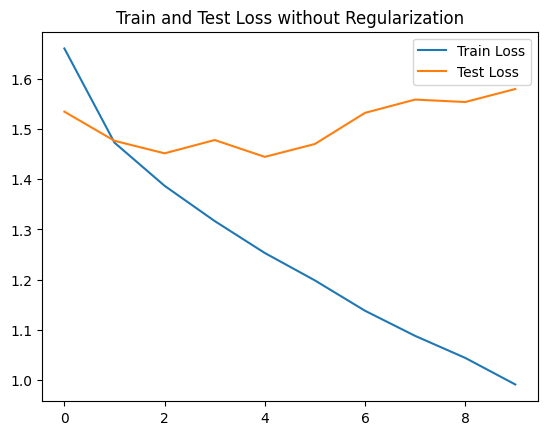

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9607843].


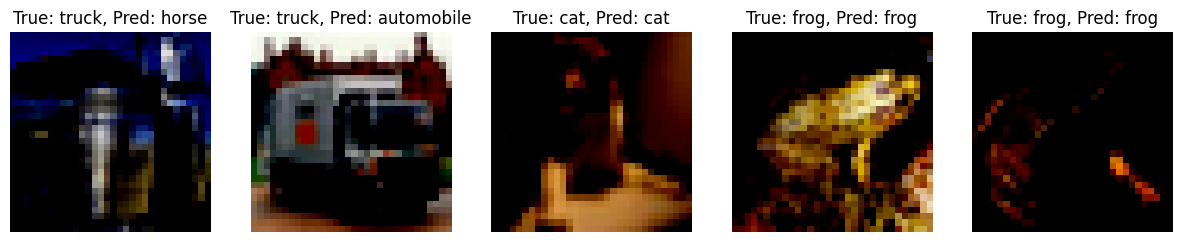

In [38]:
model = SimpleCIFARNet()
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=10, lr=0.001)

## CIFARNeuralNetWithDropout

Epoch 1/15, Train Loss: 1.9083, Test Loss: 1.7904, Accuracy: 0.3569
Epoch 2/15, Train Loss: 1.8722, Test Loss: 1.8029, Accuracy: 0.3395
Epoch 3/15, Train Loss: 1.8713, Test Loss: 1.7953, Accuracy: 0.3493
Epoch 4/15, Train Loss: 1.8726, Test Loss: 1.8087, Accuracy: 0.3666
Epoch 5/15, Train Loss: 1.8720, Test Loss: 1.7972, Accuracy: 0.3562
Epoch 6/15, Train Loss: 1.8727, Test Loss: 1.7951, Accuracy: 0.3582
Epoch 7/15, Train Loss: 1.8767, Test Loss: 1.7774, Accuracy: 0.3586
Epoch 8/15, Train Loss: 1.8734, Test Loss: 1.8097, Accuracy: 0.3628
Epoch 9/15, Train Loss: 1.8725, Test Loss: 1.8387, Accuracy: 0.3331
Epoch 10/15, Train Loss: 1.8733, Test Loss: 1.8084, Accuracy: 0.3524
Epoch 11/15, Train Loss: 1.8730, Test Loss: 1.8370, Accuracy: 0.3463
Epoch 12/15, Train Loss: 1.8758, Test Loss: 1.7789, Accuracy: 0.3685
Epoch 13/15, Train Loss: 1.8717, Test Loss: 1.7830, Accuracy: 0.3615
Epoch 14/15, Train Loss: 1.8743, Test Loss: 1.7902, Accuracy: 0.3581
Epoch 15/15, Train Loss: 1.8720, Test Loss:

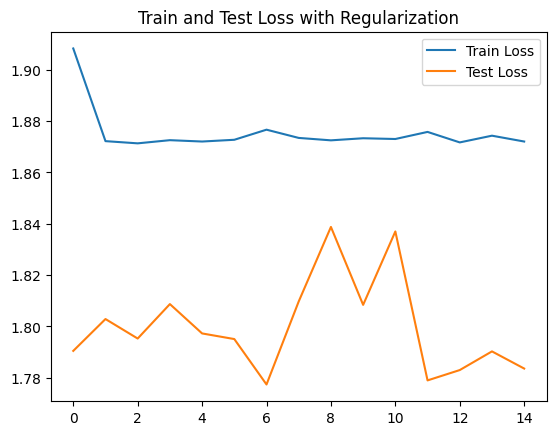

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.47450984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54509807..0.90588236].


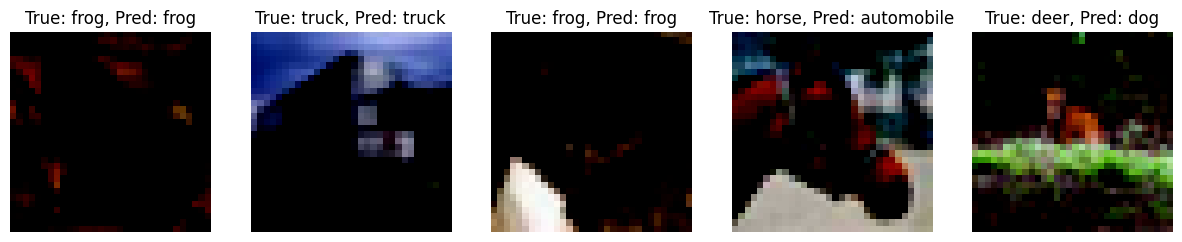

In [39]:
model = CIFARNeuralNetWithDropout()
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=15, lr=0.001, weight_decay=0.01)

Epoch 1/20, Train Loss: 1.8738, Test Loss: 1.6742, Accuracy: 0.4117
Epoch 2/20, Train Loss: 1.7097, Test Loss: 1.6079, Accuracy: 0.4385
Epoch 3/20, Train Loss: 1.6604, Test Loss: 1.5668, Accuracy: 0.4563
Epoch 4/20, Train Loss: 1.6245, Test Loss: 1.5424, Accuracy: 0.4603
Epoch 5/20, Train Loss: 1.6056, Test Loss: 1.5267, Accuracy: 0.4637
Epoch 6/20, Train Loss: 1.5884, Test Loss: 1.5163, Accuracy: 0.4713
Epoch 7/20, Train Loss: 1.5740, Test Loss: 1.5101, Accuracy: 0.4767
Epoch 8/20, Train Loss: 1.5609, Test Loss: 1.4848, Accuracy: 0.4821
Epoch 9/20, Train Loss: 1.5493, Test Loss: 1.4794, Accuracy: 0.4849
Epoch 10/20, Train Loss: 1.5451, Test Loss: 1.4771, Accuracy: 0.4858
Epoch 11/20, Train Loss: 1.5395, Test Loss: 1.4624, Accuracy: 0.4927
Epoch 12/20, Train Loss: 1.5323, Test Loss: 1.4620, Accuracy: 0.4929
Epoch 13/20, Train Loss: 1.5303, Test Loss: 1.4537, Accuracy: 0.4935
Epoch 14/20, Train Loss: 1.5241, Test Loss: 1.4603, Accuracy: 0.4922
Epoch 15/20, Train Loss: 1.5218, Test Loss:

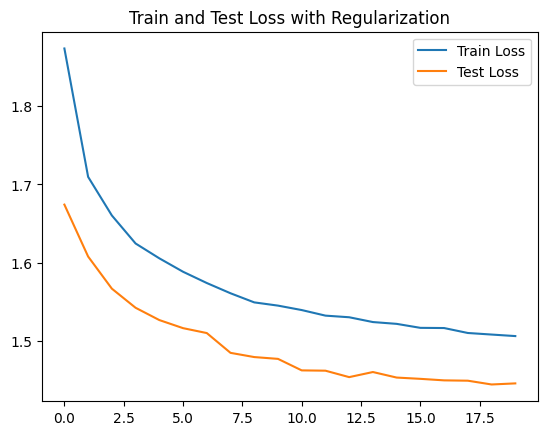

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


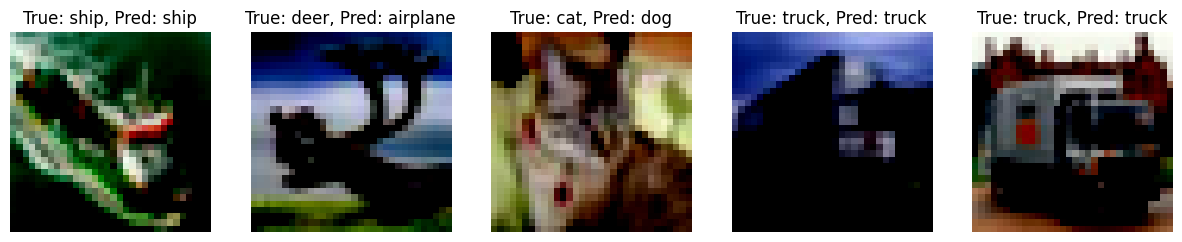

In [40]:
model = CIFARNeuralNetWithDropout()
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=20, lr=0.0001, weight_decay=0.01)

## EnhancedCIFARNet

Epoch 1/25, Train Loss: 1.4102, Test Loss: 1.1245, Accuracy: 0.6075
Epoch 2/25, Train Loss: 1.0392, Test Loss: 0.9955, Accuracy: 0.6441
Epoch 3/25, Train Loss: 0.9076, Test Loss: 0.9450, Accuracy: 0.6660
Epoch 4/25, Train Loss: 0.8160, Test Loss: 0.8220, Accuracy: 0.7115
Epoch 5/25, Train Loss: 0.7513, Test Loss: 0.8363, Accuracy: 0.7044
Epoch 6/25, Train Loss: 0.6983, Test Loss: 0.7515, Accuracy: 0.7336
Epoch 7/25, Train Loss: 0.6504, Test Loss: 0.7547, Accuracy: 0.7356
Epoch 8/25, Train Loss: 0.6118, Test Loss: 0.7681, Accuracy: 0.7344
Epoch 9/25, Train Loss: 0.5703, Test Loss: 0.7017, Accuracy: 0.7548
Epoch 10/25, Train Loss: 0.5353, Test Loss: 0.7399, Accuracy: 0.7400
Epoch 11/25, Train Loss: 0.4993, Test Loss: 0.7250, Accuracy: 0.7526
Epoch 12/25, Train Loss: 0.4676, Test Loss: 0.6997, Accuracy: 0.7585
Epoch 13/25, Train Loss: 0.4371, Test Loss: 0.6984, Accuracy: 0.7577
Epoch 14/25, Train Loss: 0.4080, Test Loss: 0.6997, Accuracy: 0.7625
Epoch 15/25, Train Loss: 0.3817, Test Loss:

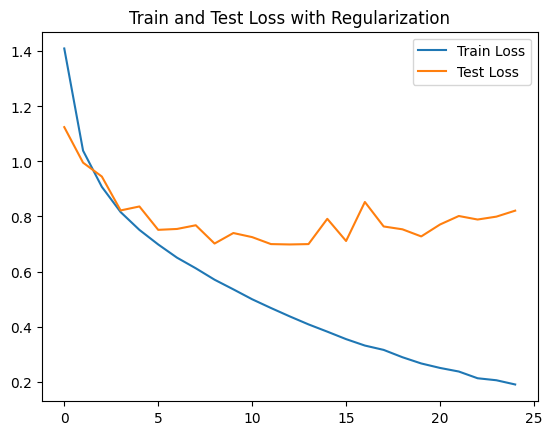

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8745098].


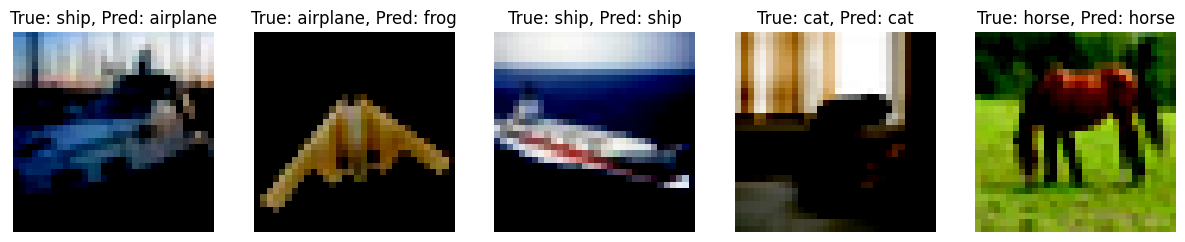

In [41]:
model = EnhancedCIFARNet(p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=25, lr=0.0001, weight_decay=0.001)

### Покращення для моделі 

#### 1. Рання зупинка (Early Stopping)
Рання зупинка дозволить зупинити навчання, якщо тестова втрата перестає зменшуватися. Це допоможе уникнути перенавчання

Додамо механізм ранньої зупинки:

#### 2. Збільшення ширини та глибини моделі
Спробуємо збільшити кількість фільтрів у згорткових шарах:

In [42]:
class EnhancedCIFARNet(BaseNeuralNetWithRegularization):
    def __init__(self, p_dropout=0.3):
        super(EnhancedCIFARNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Додавання нормалізації та Dropout
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(p=p_dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        # Визначаємо розмірність після згорткових і пулингових шарів
        test_tensor = torch.zeros(1, 3, 32, 32)  # Подаємо фейковий вхід
        out = self.pool(self.relu(self.batch_norm1(self.conv1(test_tensor))))
        out = self.pool(self.relu(self.batch_norm2(self.conv2(out))))
        out = self.pool(self.relu(self.batch_norm3(self.conv3(out))))
        flatten_size = out.view(-1).shape[0]

        # Лінійні шари
        self.fc1 = nn.Linear(flatten_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Перетворення в 1D
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.softmax(self.fc2(x))
        return x


Epoch 1/25, Train Loss: 1.2803, Test Loss: 1.0008, Accuracy: 0.6404
Epoch 2/25, Train Loss: 0.9216, Test Loss: 0.9040, Accuracy: 0.6804
Epoch 3/25, Train Loss: 0.7781, Test Loss: 0.7964, Accuracy: 0.7221
Epoch 4/25, Train Loss: 0.6863, Test Loss: 0.8376, Accuracy: 0.7118
Epoch 5/25, Train Loss: 0.6044, Test Loss: 0.7205, Accuracy: 0.7503
Epoch 6/25, Train Loss: 0.5419, Test Loss: 0.6785, Accuracy: 0.7611
Epoch 7/25, Train Loss: 0.4800, Test Loss: 0.6993, Accuracy: 0.7578
Epoch 8/25, Train Loss: 0.4206, Test Loss: 0.6548, Accuracy: 0.7740
Epoch 9/25, Train Loss: 0.3750, Test Loss: 0.6450, Accuracy: 0.7823
Epoch 10/25, Train Loss: 0.3268, Test Loss: 0.6918, Accuracy: 0.7742
Epoch 11/25, Train Loss: 0.2772, Test Loss: 0.6461, Accuracy: 0.7844
Epoch 12/25, Train Loss: 0.2448, Test Loss: 0.6919, Accuracy: 0.7767
Epoch 13/25, Train Loss: 0.2125, Test Loss: 0.7339, Accuracy: 0.7714
Epoch 14/25, Train Loss: 0.1794, Test Loss: 0.7308, Accuracy: 0.7778
Epoch 15/25, Train Loss: 0.1540, Test Loss:

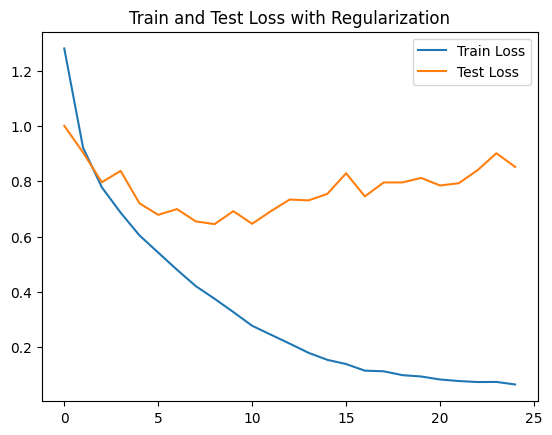

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.62352943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.3803922].


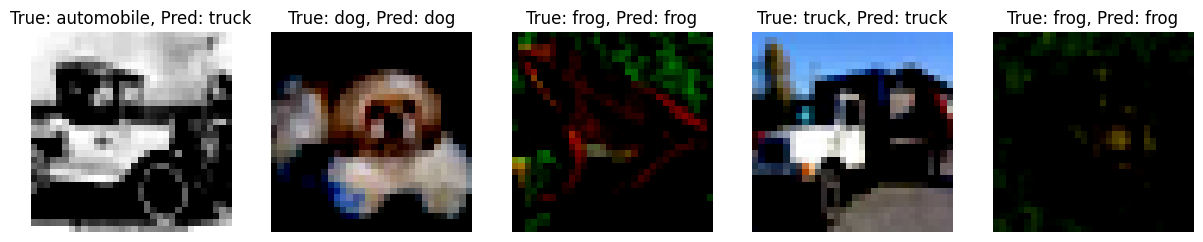

In [43]:
model = EnhancedCIFARNet(p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=25, lr=0.0001, weight_decay=0.001)